# 1、导入数据

可以直接使用PaddleTS集成的公开数据集，也可以导入自己的数据（如何导入自己的数据请参考TSDataset相关使用文档）  

在这个例子里面，我们使用NAB中的一份温度数据集，NAB是一份比较经典的用于时序异常检测的数据集，详情可参考https://github.com/numenta/NAB  

NAB温度数据集已经集成在PaddleTS公开数据集中，可以直接使用下面两行代码导入  

In [3]:
from paddlets.datasets.repository import get_dataset
ts_data = get_dataset('NAB_TEMP')

In [2]:
ts_data

                     label      value
timestamp                            
2013-12-02 21:15:00      0  73.967322
2013-12-02 21:20:00      0  74.935882
2013-12-02 21:25:00      0  76.124162
2013-12-02 21:30:00      0  78.140707
2013-12-02 21:35:00      0  79.329836
...                    ...        ...
2014-02-19 15:05:00      0  98.185415
2014-02-19 15:10:00      0  97.804168
2014-02-19 15:15:00      0  97.135468
2014-02-19 15:20:00      0  98.056852
2014-02-19 15:25:00      0  96.903861

[22683 rows x 2 columns]

# 2、数据可视化

导入数据后，可以通过PaddleTS提供的可视化算子展示数据的具体情况

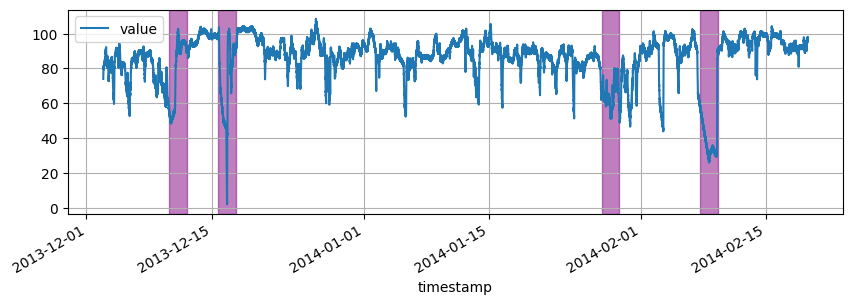

In [4]:
#导入可视化算子
from paddlets.utils.utils import plot_anoms
plot_anoms(origin_data=ts_data, feature_name="value")

# 3、数据预处理

在正式进行建模之前，确定训练集和测试集（在这个例子中，我们用前15%的数据进行训练，后85%的数据用于测试）   

之后我们对数据进行标准化处理

In [5]:
from paddlets.transform import StandardScaler
# 据集拆分
train_tsdata, test_tsdata = ts_data.split(0.15)
# 标准化
scaler = StandardScaler()
scaler.fit(train_tsdata)
train_data_scaled = scaler.transform(train_tsdata)
test_data_scaled = scaler.transform(test_tsdata)

# 4、模型训练

完成数据预处理之后，我们就可以进行模型训练了，在这个例子中，我们采用AutoEncoder模型对数据进行训练

In [6]:
import paddle
import numpy as np

# 固定随机随机种子，保证训练结果可复现
seed = 2022
paddle.seed(seed)
np.random.seed(seed)

#建模与训练
from paddlets.models.anomaly import AutoEncoder
model = AutoEncoder(
    in_chunk_len=2, # 样本数据窗口大小
    max_epochs=100  # 最大epoch设为100
)
model.fit(train_data_scaled)

[2022-11-10 16:33:05,775] [paddlets.models.anomaly.dl.anomaly_base] [WARNING] No early stopping will be performed, last training weights will be used.
[2022-11-10 16:33:06,045] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.322022| 0:00:00s
[2022-11-10 16:33:06,293] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.085059| 0:00:00s
[2022-11-10 16:33:06,533] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.064829| 0:00:00s
[2022-11-10 16:33:06,780] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.052350| 0:00:01s
[2022-11-10 16:33:07,025] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.047867| 0:00:01s
[2022-11-10 16:33:07,273] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.045785| 0:00:01s
[2022-11-10 16:33:07,519] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.041525| 0:00:01s
[2022-11-10 16:33:07,771] [paddlets.models.common.c

# 5、模型预测和评估

模型训练完成之后，可以对测试集进行预测并评估   

评估的指标采用F1,Precision,Recall，PaddleTS已经基于TSDataset实现了这三个指标的计算，直接调用即可

In [7]:
from paddlets.metrics import F1, Precision, Recall
# 预测
pred_label = model.predict(test_data_scaled)
lable_name = pred_label.target.data.columns[0]
# 计算评估指标 f1, precision, recall
f1 = F1()(test_tsdata, pred_label)
precision = Precision()(test_tsdata, pred_label)
recall = Recall()(test_tsdata, pred_label)
print ('f1: ', f1[lable_name])
print ('precision: ', precision[lable_name])
print ('recall: ', recall[lable_name])

[2022-11-10 16:33:48,036] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!
[2022-11-10 16:33:48,055] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!
[2022-11-10 16:33:48,072] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!


f1:  0.4904181184668989
precision:  0.946218487394958
recall:  0.33098177542621987


# 6、模型结果可视化 

可以将模型的预测结果和真实异常做对比，更加直观的查看模型预测的效果

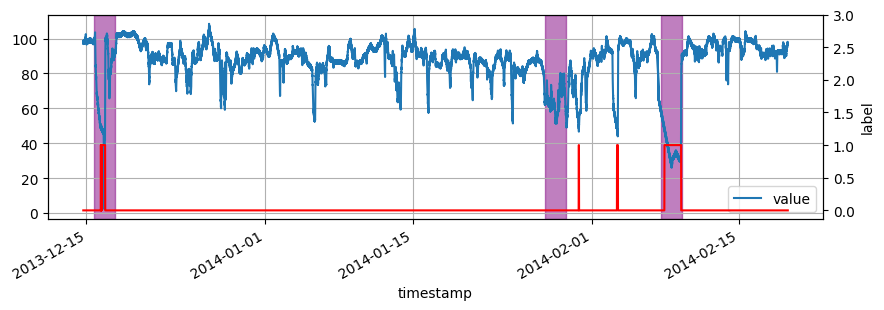

In [8]:
# 预测值与真实值
plot_anoms(origin_data=test_tsdata, predict_data=pred_label, feature_name="value")

在异常检测场景中，PaddleTS除了提供predict接口预测每个时间点是否异常，还提供了predict_score接口获得每个时间点的异常分数，分数越高，表示该点越可能是异常

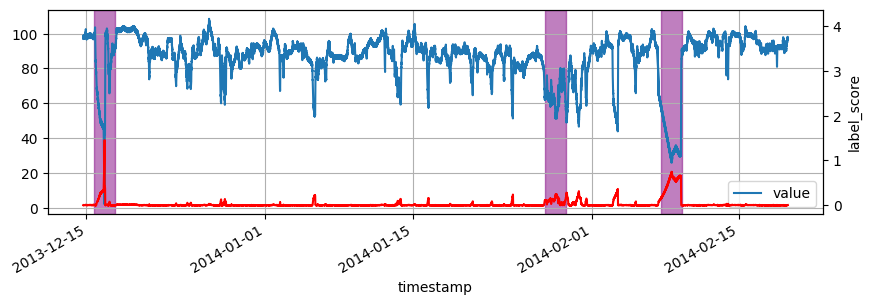

In [10]:
# 异常评分与真实值
pred_score = model.predict_score(test_data_scaled)
plot_anoms(origin_data = test_tsdata, predict_data=pred_score, feature_name = "value")